<a href="https://colab.research.google.com/github/YB0223/Project1/blob/main/Project1_%ED%9D%91%EB%B0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### pip setting

In [1]:
# GIF를 만들기위해 설치합니다.
!pip install imageio

In [ ]:
!pip install tensorflow-gpu==2.0.0

## New Face

### DATA EDA

#### 1.

데이터 원본링크 : 
https://research.google/tools/datasets/google-facial-expression/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root='/content/drive/MyDrive/FEC_dataset'
train_path=root+'/faceexp-comparison-data-train-public.csv'
test_path=root+'/faceexp-comparison-data-test-public.csv'

In [5]:
import csv
import pandas as pd
with open(train_path, encoding='utf8') as f, open(test_path, encoding='utf8') as g:
  r1=csv.reader(f)
  r2=csv.reader(g)
  csv_train_list=[] 
  csv_test_list=[] 
  for i in r1: 
    csv_train_list.append(i) 
  for i in r2: 
    csv_test_list.append(i) 

train=pd.DataFrame(csv_train_list)
test=pd.DataFrame(csv_test_list)

In [6]:
train=train.iloc[:,:15]
test=test.iloc[:,:15]

In [ ]:
'''col_name=['link1','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight',
               'link2','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight',
               'link3','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight']
train.columns=col_name
test.columns=col_name'''

"col_name=['link1','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight',\n               'link2','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight',\n               'link3','ColWidth_TopLeft','ColWidth_BottomRight','RowHeight_TopLeft','RowHeight_BottomRight']\ntrain.columns=col_name\ntest.columns=col_name"

In [7]:
train.shape, test.shape

((449143, 15), (51060, 15))

In [8]:
from urllib import request
import time
from io import BytesIO
from PIL import Image
import cv2
import numpy as np

In [9]:
def get_image(url_row,url_col):
  url = train[url_col][url_row]
  try:
    res = request.urlopen(url).read()
  except:
    return -1
  img = Image.open(BytesIO(res)).convert('L')

  dot1=[int(float(train[1+url_col][url_row])*img.size[0]),int(float(train[3+url_col][url_row])*img.size[1])]  #좌상점
  dot2=[int(float(train[2+url_col][url_row])*img.size[0]),int(float(train[4+url_col][url_row])*img.size[1])]  #우하점
  gap=dot2[1]-dot1[1]-(dot2[0]-dot1[0])
  #정방향 이미지로 변경
  gap0=gap//2
  gap1=gap%2
  dot1[0]=dot1[0]-gap0
  dot2[0]=dot2[0]+gap0+gap1
  img2=img.crop((dot1[0],dot1[1],dot2[0],dot2[1]))

  #사이즈 재설정
  img2=img2.resize((28,28))

  return img2,img

####긴 처리1

In [10]:
from google.colab import output

origin_image=[]
train_images=[]
val=200

s_time=time.time()
for j in range(val):
  start = time.time()

  for i in range (3):
    img=get_image(j,5*i)
    if img == -1:
      continue
    img=img[0]
    origin_image.append(img)
    img=np.array(img)
    train_images.append(img)

  # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
  output.clear()
  print ('Time for row {}/{} is {} sec'.format(j + 1,val, round(time.time()-start,2)))
  print ('Time for all is {} sec'.format(round(time.time()-s_time,2)))
  

Time for row 200/200 is 0.68 sec
Time for all is 140.9 sec


#### 이어서

In [ ]:
'''for i in range(4,9):
  display(image[5*i],image[5*i+1],image[5*i+2],image[5*i+3],image[5*i+4])'''

In [11]:
train_images=np.array(train_images)
train_images=(train_images-127.5)/127.5

train_images=train_images.reshape(train_images.shape[0],28,28,1)

### DCGAN

In [12]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display as dp

In [13]:
tf.__version__

'2.7.0'

In [14]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 32

In [15]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### 생성자

In [16]:
input_row=100

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(input_row,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 28, 28, 1)

    return model

(None, 28, 28, 1)


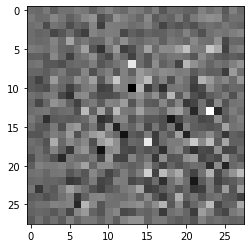

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, input_row])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0],cmap='gray')

#### 감별자

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (10, 10), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00082863]], shape=(1, 1), dtype=float32)


#### 손실함수 옵티마이저 정의

In [21]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
#감별자 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
#생성자 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 체크포인트 저장

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### 훈련루프 정의

In [29]:
EPOCHS = 1500
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      print(f"gen_loss: {gen_loss},disc_loss: {disc_loss}")

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
#이미지생성 및 저장
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
def train(dataset, epochs):
  s_time=time.time()
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    dp.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time()-start,2)))
    print ('Time for all is {} sec'.format(round(time.time()-s_time,2)))
  # 마지막 에포크가 끝난 후 생성합니다.
  dp.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### 모델훈련

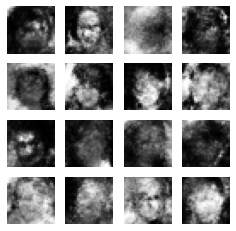

In [30]:
train(train_dataset, EPOCHS)

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [32]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

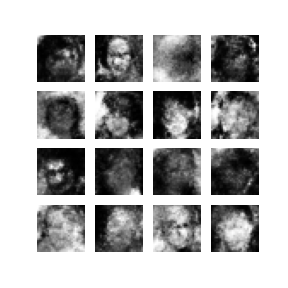

In [33]:
display_image(EPOCHS)

In [34]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [35]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
for i in range(977):
  files.download('image_at_epoch_{:04d}.png'.format(i+1))